In [1]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pickle
# from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score,accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from datetime import date
from sklearn.tree import plot_tree
import seaborn as sns
# from xgboost import XGBRegressor
import lightgbm as lgb
import optuna
import warnings
# from tpot import TPOTRegressor
import optuna
import joblib
import os 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
os.getcwd()

os.chdir('c:\\Users\\Saidakbar\\Desktop\\Link Data home car full projects\\LINK DATA SAIDAKBAR\\LINK AUTO ALL FILES\\LINK AUTO SORTED')

In [3]:
from Target_encoder import TargetEncoder

brand_type
1    689037
0    133804
Name: count, dtype: int64


<Axes: xlabel='price', ylabel='Count'>

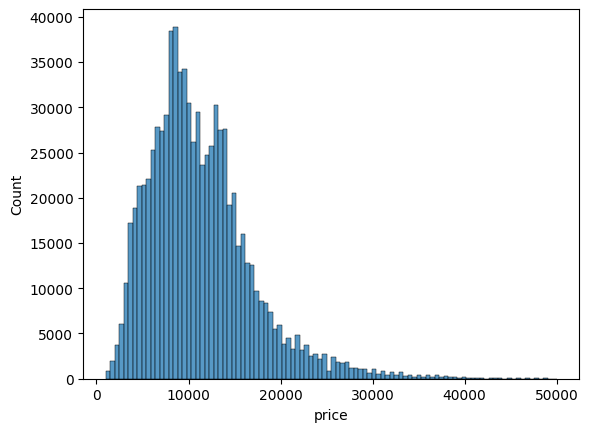

In [4]:

data= pd.read_csv(r"C:\Users\Saidakbar\Desktop\Link Data home car full projects\LINK DATA SAIDAKBAR\LINK AUTO ALL FILES\LINK AUTO SORTED\Datasets\CHEVROLET_DAEWOO_RAVON_1.csv")
data2 = pd.read_csv(r"C:\Users\Saidakbar\Desktop\Link Data home car full projects\LINK DATA SAIDAKBAR\LINK AUTO ALL FILES\LINK AUTO SORTED\Datasets\CHEVROLET_DAEWOO_RAVON_2.csv")
data3=pd.read_csv(r"C:\Users\Saidakbar\Desktop\Link Data home car full projects\LINK DATA SAIDAKBAR\LINK AUTO ALL FILES\LINK AUTO SORTED\Datasets\CHEVROLET_DAEWOO_RAVON_3.csv")
print(data['brand_type'].value_counts())
sns.histplot(data['price'],bins=100)

In [5]:
data.rename(columns={'car_condition_Needs Repair': 'car_condition_Needs_Repair',
                     'Air Conditioner': 'Air_Conditioner',
                     'Security System':'Security_System',
                        'Parking Sensors': 'Parking_Sensors',
       'Customs Cleared':'Customs_Cleared', 
       'Power Windows':'Power_Windows', 
       'Power Mirrors': 'Power_Mirrors'},
             inplace=True)
data = data.drop(columns=['color_Beige'])
cols = [ 'body_Coupe', 'body_Hatchback', 'body_Minivan','body_Pickup',
       'body_SUV', 'body_Sedan', 'body_Wagon']

data2['body_Other'] = (data2[cols].sum(axis=1) == 0).astype(int)
cols2 = ['body_Other', 'body_Coupe', 'body_Hatchback', 'body_Minivan','body_Pickup',
       'body_SUV', 'body_Sedan', 'body_Wagon']

data2['body_Convertible'] = (data2[cols2].sum(axis=1) == 0).astype(int)



In [6]:
data.shape,data2.shape,data3.shape

((822841, 65), (78807, 65), (103037, 64))

In [7]:
data = pd.concat([data, data2,data3], ignore_index=True)
print('numer of duplicates',data.duplicated().sum())
data = data.drop_duplicates()

numer of duplicates 0


In [8]:
data.shape

(1004685, 65)

In [9]:
def display_outlier_bounds(df, cols, factor=1.5):
    bounds = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        bounds[col] = (lower_bound, upper_bound)
        print(f"{col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")
    return bounds

# Define columns
cols_to_clean = ['price', 'mileage', 'release_year', 'engine_volume']

# Get and print outlier bounds
outlier_bounds = display_outlier_bounds(data, cols_to_clean)


price: Lower Bound = -3200.0, Upper Bound = 24000.0
mileage: Lower Bound = -225250.0, Upper Bound = 384750.0
release_year: Lower Bound = 1999.5, Upper Bound = 2035.5
engine_volume: Lower Bound = 0.09999999999999987, Upper Bound = 2.5


In [10]:
data=data[(data['price'] >= 1000) & (data['price'] <= 175000)]
data=data[(data['mileage'] >= 0) & (data['mileage'] <= 400000)]
data=data[(data['release_year'] >= 1980) & (data['release_year'] <= 2025)]
data=data[(data['engine_volume'] >= 0) & (data['engine_volume'] <= 10)]
data.shape

(996198, 65)

In [11]:
data.shape

(996198, 65)

In [12]:
x=data[['car_name','brand_type']]
x[x['brand_type']==0]

,car_name,brand_type
31,Lacetti,0
49,Nexia I,0
52,Lacetti,0
53,Lacetti,0
54,Lacetti,0
...,...,...
1004645,Matiz,0
1004647,Nexia I,0
1004648,Damas,0
1004669,Epica,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996198 entries, 0 to 1004684
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  996198 non-null  int64  
 1   price                       996198 non-null  float64
 2   transmission                996198 non-null  int64  
 3   mileage                     996198 non-null  float64
 4   release_year                996198 non-null  float64
 5   engine_volume               996198 non-null  float64
 6   month                       996198 non-null  float64
 7   year                        996198 non-null  float64
 8   month_year                  996198 non-null  object 
 9   brand_type                  996198 non-null  int64  
 10  item_type_Business          996198 non-null  bool   
 11  item_type_Private           996198 non-null  bool   
 12  owners_count_4              996198 non-null  bool   
 13  owners_count_0    

# TARGET ENCODING

In [14]:
import numpy as np

data = data.drop(columns=['Unnamed: 0'])

fuel_map = {
    'fuel_type_Diesel': 'diesel',
    'fuel_type_Electric': 'electric',
    'fuel_type_Gasoline': 'gasoline',
    'fuel_type_Gasoline/Petrol': 'gasoline/petrol',
    'fuel_type_Hybrid': 'hybrid'
}
data['fuel_type'] = np.select(
    [data[col] == 1 for col in fuel_map.keys()],
    list(fuel_map.values()),
    default='other'
)

item_map = {
    'item_type_Business': 'business',
    'item_type_Private': 'private'
}
data['item_type'] = np.select(
    [data[col] == 1 for col in item_map.keys()],
    list(item_map.values()),
    default='unknown'
)

owner_map = {
    'owners_count_0': '0',
    'owners_count_1': '1',
    'owners_count_2': '2',
    'owners_count_3': '3',
    'owners_count_4': '4'
}
data['owners_count'] = np.select(
    [data[col] == 1 for col in owner_map.keys()],
    list(owner_map.values()),
    default='unknown'
)

condition_map = {
    'car_condition_Average': 'average',
    'car_condition_Excellent': 'excellent',
    'car_condition_Good': 'good',
    'car_condition_Needs_Repair': 'needs repair'
}
data['car_condition'] = np.select(
    [data[col] == 1 for col in condition_map.keys()],
    list(condition_map.values()),
    default='unknown'
)

color_cols = [c for c in data.columns if c.startswith("color_")]
data['color'] = data[color_cols].idxmax(axis=1).str.replace("color_", "")

body_cols = [c for c in data.columns if c.startswith("body_")]
data['body_type'] = data[body_cols].idxmax(axis=1).str.replace("body_", "")

state_cols = [c for c in data.columns if c.startswith("state_")]
data['state'] = data[state_cols].idxmax(axis=1).str.replace("state_", "")


In [15]:
# data.drop(columns=['body_Convertible', 'car_name', 'fuel_type', 'item_type',
#        'owners_count', 'car_condition', 'color', 'body_type', 'state'],inplace=True)

In [16]:
data.drop(columns=['item_type_Business',
       'item_type_Private', 'owners_count_4', 'owners_count_0',
       'owners_count_1', 'owners_count_2', 'owners_count_3',
       'car_condition_Average', 'car_condition_Excellent',
       'car_condition_Good', 'car_condition_Needs_Repair', 'fuel_type_Diesel',
       'fuel_type_Electric', 'fuel_type_Gasoline', 'fuel_type_Gasoline/Petrol',
       'fuel_type_Hybrid', 'fuel_type_Other', 'color_Asphalt', 'color_Black',
       'color_Blue', 'color_Brown', 'color_Gray', 'color_Other',
       'color_Silver', 'color_White', 'body_Convertible', 'body_Coupe',
       'body_Hatchback', 'body_Minivan', 'body_Other', 'body_Pickup',
       'body_SUV', 'body_Sedan', 'body_Wagon', 'state_Andijon',
       'state_Bukhara', 'state_Ferghana', 'state_Jizzakh', 'state_Namangan',
       'state_Navoiy', 'state_Kashkadarya', 'state_Karakalpakstan',
       'state_Samarkand', 'state_Sirdaryo', 'state_Surkhondaryo',
       'state_Tashkent', 'state_Tashkent2', 'state_Khorezm'],inplace=True)

In [17]:
data['month_year'] = pd.to_datetime(data['month_year'])
data.drop(columns=['month', 'year'], inplace=True)



In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996198 entries, 0 to 1004684
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   price            996198 non-null  float64       
 1   transmission     996198 non-null  int64         
 2   mileage          996198 non-null  float64       
 3   release_year     996198 non-null  float64       
 4   engine_volume    996198 non-null  float64       
 5   month_year       996198 non-null  datetime64[ns]
 6   brand_type       996198 non-null  int64         
 7   car_name         996198 non-null  object        
 8   Air_Conditioner  996198 non-null  int64         
 9   Security_System  996198 non-null  int64         
 10  Parking_Sensors  996198 non-null  int64         
 11  Customs_Cleared  996198 non-null  int64         
 12  Power_Windows    996198 non-null  int64         
 13  Power_Mirrors    996198 non-null  int64         
 14  fuel_type        996198 

In [19]:
# def time_index(data):
#     data['month_year'] = pd.to_datetime(data['month_year'], format='%Y-%m-%d')

#     data = data.sort_values(by='month_year').reset_index(drop=True)
#     data['time_index'] = (data['month_year'].dt.year - data['month_year'].dt.year.min()) * 12 + data['month_year'].dt.month
#     data['month'] = data['month_year'].dt.month

#     data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
#     data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
#     data.drop(columns=['month_year'],inplace=True)
#     return data


def add_time_features_from_month_year(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # Convert month_year to datetime
    df["date"] = pd.to_datetime(df[col], format="%Y-%m", errors="coerce")
    
    # Extract year and month
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    
    # Sort by date
    df = df.sort_values("date").reset_index(drop=True)
    
    # Time index: counts months since first entry
    df["time_idx"] = (df["year"] - df["year"].min()) * 12 + (df["month"] - df["month"].min())
    
    # Cyclical encoding for month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    
    return df
data = add_time_features_from_month_year(data,'month_year')
data= data.drop(columns=['month','month_year','date'])



In [20]:
data['brand_type']

0         1
1         1
2         1
3         1
4         0
         ..
996193    1
996194    1
996195    1
996196    1
996197    1
Name: brand_type, Length: 996198, dtype: int64

In [21]:
data[['car_name','state','car_condition','color','body_type','fuel_type','item_type','color']].to_csv('Car_State_name.csv',index=False)

In [22]:


#removing spcaces from data columns
data.columns = data.columns.str.replace(' ','_')

train_data,test_data = train_test_split(data,test_size=0.2,random_state=42)


In [23]:
cat_cols = data.select_dtypes('object')
cat_cols.columns


Index(['car_name', 'fuel_type', 'item_type', 'owners_count', 'car_condition',
       'color', 'body_type', 'state'],
      dtype='object')

In [24]:
data.groupby('car_condition')['price'].agg(['mean'])

,mean
car_condition,
average,5162.888587
excellent,12216.422369
good,9197.066731
needs repair,4964.695122


In [25]:
data

,price,transmission,mileage,release_year,engine_volume,brand_type,car_name,Air_Conditioner,Security_System,Parking_Sensors,Customs_Cleared,Power_Windows,Power_Mirrors,fuel_type,item_type,owners_count,car_condition,color,body_type,state,year,time_idx,month_sin,month_cos
0,5500.0,1,4005.0,2011.0,1.2,1,Spark,0,1,0,0,0,1,gasoline/petrol,private,1,good,Gray,Hatchback,Tashkent2,2023,2,1.0,6.123234e-17
1,19500.0,0,3500.0,2022.0,1.6,1,Gentra,1,1,1,0,1,1,gasoline,private,0,excellent,Black,Sedan,Tashkent,2023,2,1.0,6.123234e-17
2,7000.0,1,250000.0,2012.0,1.5,1,Nexia II,1,1,1,1,1,1,gasoline/petrol,private,1,good,White,Sedan,Jizzakh,2023,2,1.0,6.123234e-17
3,18500.0,0,22000.0,2022.0,1.6,1,Gentra,1,1,1,0,0,0,gasoline,private,0,excellent,Black,Sedan,Bukhara,2023,2,1.0,6.123234e-17
4,4800.0,1,206000.0,2008.0,1.0,0,Matiz,0,1,0,1,0,1,other,private,1,good,Silver,Hatchback,Bukhara,2023,2,1.0,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996193,10300.0,0,52000.0,2022.0,1.5,1,Nexia III,1,1,1,1,1,1,gasoline,private,1,excellent,Asphalt,Sedan,Tashkent2,2025,26,1.0,6.123234e-17
996194,16000.0,0,40000.0,2022.0,3.0,1,Gentra,1,0,0,0,1,1,gasoline/petrol,private,1,excellent,White,Sedan,Ferghana,2025,26,1.0,6.123234e-17
996195,7700.0,1,69000.0,2015.0,1.0,1,Nexia II,1,0,0,0,0,0,gasoline/petrol,private,1,good,White,Sedan,Samarkand,2025,26,1.0,6.123234e-17
996196,6700.0,1,93000.0,2012.0,1.3,1,Spark,0,0,0,0,0,0,gasoline/petrol,private,1,excellent,Blue,Hatchback,Bukhara,2025,26,1.0,6.123234e-17


In [26]:
encoder = TargetEncoder()
cat_cols = data.select_dtypes('object')
target='price'
train_data=encoder.fit_transform(train_data,cat_cols,target)
test_data =encoder.transform(test_data,cat_cols)


with open("target_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

shape (796958, 24)


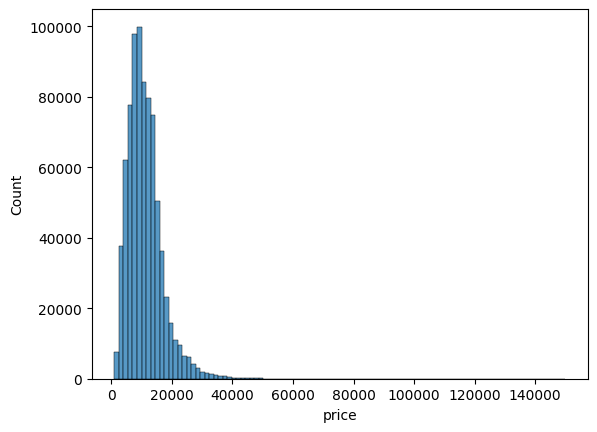

In [27]:
sns.histplot(train_data['price'],bins=100)
print('shape',train_data.shape)

In [29]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination='auto', random_state=42)
labels = iso.fit_predict(train_data)

train_data = train_data[labels == 1]


shape (388477, 24)


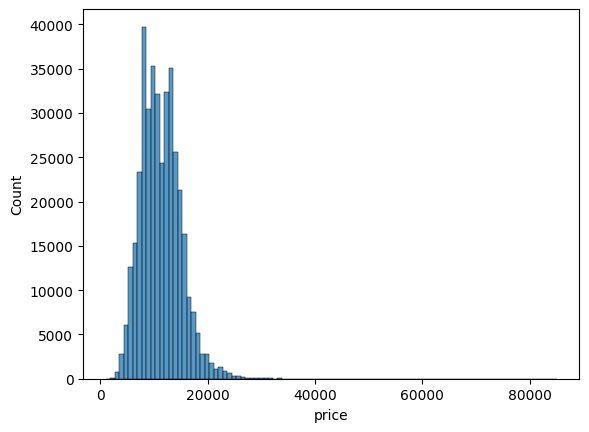

In [30]:
sns.histplot(train_data['price'],bins=100)
print('shape',train_data.shape)

In [31]:
y_train=train_data['price']
x_train=train_data.drop(columns=['price'])

X_test= test_data.drop(columns=['price'])
Y_test=test_data['price']
x_test,x_val,y_test,y_val = train_test_split(X_test,Y_test,test_size=0.5,random_state=42)

In [32]:
x_train.head(1).to_csv('Chevrolet_DAEWOO_RAVON_columns.csv')

# lgbm

In [33]:
monotone=x_train.head(1)
for col in monotone.columns.tolist():
    monotone[col]=0
monotone['Power_Mirrors']=1 
monotone['Air_Conditioner']=1 
monotone['Customs_Cleared']=1 
monotone['Security_System']=1
monotone['Parking_Sensors']=1
monotone['Power_Windows']=1

monotone=monotone.values
monotone.reshape(-1)
monotone.tolist()

[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [34]:
# from lightgbm import early_stopping, log_evaluation

# monotone=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# #bayesian search with optuna
# def objective(trial):
#     params = {
#         "num_leaves": trial.suggest_int("num_leaves", 64, 128),
#         "max_depth": trial.suggest_int("max_depth", 5, 20),
#         "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.5),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0, 20.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0, 20.0),
#         "n_estimators": 5000,
#         "boosting_type": "gbdt",
#         "random_state": 42,
#         "n_jobs": -1,
#         "verbose": 2,
#         "device": "gpu",
#         "gpu_platform_id": 1,
#         "gpu_device_id": 1,
#         "tree_learner": "data",
#     }
#     #model
#     model = lgb.LGBMRegressor(**params,monotone_constraint=monotone)
    
#     model.fit(
#         x_train, y_train,
#         eval_set=[(x_test, y_test)],
#         eval_metric="mae",
#         callbacks=[
#             early_stopping(stopping_rounds=100),
#             log_evaluation(period=0)
#         ]
        
#     )
#     preds = model.predict(x_test)
#     mae = np.mean(np.abs(y_test - preds))  # FIXED: Use absolute values
#     return mae / y_test.mean()


# #study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50,show_progress_bar=True)

# #best parameters
# print("Best hyperparameters:", study.best_params)

# #train best hyperparameters
# best_params = study.best_params
# best_model = lgb.LGBMRegressor(**best_params, n_estimators=5000,random_state=42, n_jobs=-1)
# best_model.fit(x_train, y_train)

# y_pred = best_model.predict(x_val)
# mae = mean_absolute_error(y_val, y_pred)
# print(f"Test MAE: {mae/y_val.mean()}")

# joblib.dump(best_model,'CHEVROLET_DAEWOO_RAVON_LGBM_tencoded.pkl')


In [35]:
[I 2025-11-17 06:26:04,271] Trial 19 finished with value: 0.0859389218537715 and parameters: {'num_leaves': 115, 'max_depth': 16, 'learning_rate': 0.011659857328142542, 'min_child_samples': 43, 'subsample': 0.7014590456814958, 'colsample_bytree': 0.7779963749475288, 'min_split_gain': 0.424580036048667, 'reg_alpha': 3.4987750418979817, 'reg_lambda': 14.935560967087266}. Best is trial 19 with value: 0.0859389218537715.


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2412419951.py, line 1)

In [36]:
from sklearn.metrics import mean_squared_error

In [42]:
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)

model.fit(
    x_train,
    y_train,
    eval_set=[(x_val,y_val)],
    eval_metric='rmse'
)
preds = model.predict(x_val)
mae = mean_absolute_error(y_val, preds)
rmse = np.sqrt(mean_squared_error(y_val, preds))
r2 = r2_score(y_val, preds)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 388477, number of used features: 23
[LightGBM] [Info] Start training from score 11319.572901


In [43]:
joblib.dump(model,'CHEVROLET_DAEWOO_RAVON_LGBM_tencoded.pkl')


['CHEVROLET_DAEWOO_RAVON_LGBM_tencoded.pkl']

In [41]:
model = joblib.load(r'C:\Users\Saidakbar\Desktop\Link Data home car full projects\LINK DATA SAIDAKBAR\LINK AUTO ALL FILES\LINK AUTO SORTED\Models\CHEVROLET_DAEWOO_RAVON_LGBM_tencoded.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Saidakbar\\Desktop\\Link Data home car full projects\\LINK DATA SAIDAKBAR\\LINK AUTO ALL FILES\\LINK AUTO SORTED\\Models\\CHEVROLET_DAEWOO_RAVON_LGBM_tencoded.pkl'

In [ ]:
len(model.feature_name_)

22

In [ ]:
df

,Unnamed: 0,transmission,mileage,release_year,engine_volume,month_year,brand_type,Air_Conditioner,Security_System,Parking_Sensors,Customs_Cleared,Power_Windows,Power_Mirrors,car_name_tencoded,fuel_type_tencoded,item_type_tencoded,owners_count_tencoded,car_condition_tencoded,color_tencoded,body_type_tencoded,state_tencoded
0,0,0,50000.0,2020,2.0,2025-11-15 20:42:55.394234,0,1,0,0,1,1,1,8131.492297,8858.280747,10742.193067,11814.817334,9193.573058,8011.633761,8484.307687,9901.66673


In [ ]:
import pickle

In [ ]:
import os 

In [ ]:
os.chdir('c:\\Users\\Saidakbar\\Desktop\\Link Data home car full projects\\LINK DATA SAIDAKBAR\\LINK AUTO ALL FILES\\LINK AUTO SORTED')
with open(r'C:\Users\Saidakbar\Desktop\Link Data home car full projects\LINK DATA SAIDAKBAR\LINK AUTO ALL FILES\LINK AUTO SORTED\Models\target_encoder.pkl','rb') as f:
    encoder = pickle.load(f)

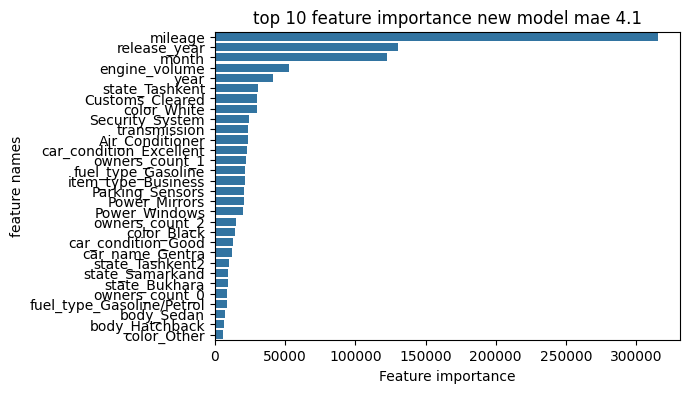

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

importances = model.feature_importances_
feature_names = X.columns  

sorted_idx = np.argsort(importances)[::-1]
top_features = feature_names[sorted_idx][:30]
top_importances = importances[sorted_idx][:30]

plt.figure(figsize=(6, 4))
sns.barplot(x=top_importances, y=top_features)
plt.xlabel("Feature importance")
plt.ylabel("feature names")
plt.title("top 10 feature importance old del mae 4.1")
plt.show()


In [ ]:
df=pd.read_csv(r'C:\Users\Saidakbar\Desktop\Link Data home car full projects\LINK DATA SAIDAKBAR\LINK AUTO ALL FILES\LINK AUTO SORTED\to_test.csv')
df.shape

(1, 24)

In [ ]:
df

,Unnamed: 0,transmission,mileage,release_year,engine_volume,brand_type,Air_Conditioner,Security_System,Parking_Sensors,Customs_Cleared,Power_Windows,Power_Mirrors,car_name_tencoded,fuel_type_tencoded,item_type_tencoded,owners_count_tencoded,car_condition_tencoded,color_tencoded,body_type_tencoded,state_tencoded,time_index,month,month_sin,month_cos
0,0,0,50000.0,2020,2.0,0,1,0,0,1,1,1,8131.492297,8858.280747,10742.193067,11814.817334,9193.573058,8011.633761,8484.307687,9901.66673,11,11,-0.5,0.866025
